# Step 1: Load and Prepare the Dataset
We load the Wine dataset from sklearn and explore its features and class distribution.  
To ensure all features have equal weight in clustering, we apply z-score normalization (standardization).


In [1]:
# Import libraries
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load dataset
wine = load_wine()
X = wine.data
y = wine.target

# Convert to DataFrame for easy exploration
df = pd.DataFrame(X, columns=wine.feature_names)
df['class'] = y

# Explore dataset
print("Features:", wine.feature_names)
print("Classes:", wine.target_names)
print(df['class'].value_counts())

# Standardize the data (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes: ['class_0' 'class_1' 'class_2']
class
1    71
0    59
2    48
Name: count, dtype: int64


# Step 2: Implement K-Means Clustering
We apply the K-Means algorithm with **k = 3**, as the Wine dataset contains three classes.  
After fitting the model, we obtain the predicted cluster labels.  
To evaluate the quality of the clusters, we calculate:
- **Silhouette Score** – to measure how well-separated the clusters are.  
- **Adjusted Rand Index (ARI)** – to compare the clustering results with the actual class labels.


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Apply K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")
print(f"K-Means ARI: {kmeans_ari:.3f}")


K-Means Silhouette Score: 0.285
K-Means ARI: 0.897


# Step 3: Implement K-Medoids Clustering
We apply the K-Medoids algorithm with **k = 3**.  
Similar to K-Means, we obtain cluster labels and evaluate the clustering results.  
We compute the same metrics as in K-Means:
- **Silhouette Score** – cluster separation quality.  
- **Adjusted Rand Index (ARI)** – how closely the clustering matches true labels.


In [15]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

# Calculate distance matrix
distance_matrix = calculate_distance_matrix(X_scaled)

# Choose 3 initial medoids (random sample indices)
initial_medoids = [0, 50, 100]

# Create and run K-Medoids
kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
kmedoids_instance.process()

# Extract clusters and medoid indices
clusters = kmedoids_instance.get_clusters()
medoid_indices = np.array(kmedoids_instance.get_medoids())  # <--- THIS DEFINES medoid_indices

# Create labels for all points
kmedoids_labels = np.zeros(len(X_scaled))
for cluster_id, cluster in enumerate(clusters):
    for point_idx in cluster:
        kmedoids_labels[point_idx] = cluster_id

# Evaluate metrics
kmedoids_silhouette = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_ari = adjusted_rand_score(y, kmedoids_labels)

print(f"K-Medoids Silhouette Score: {kmedoids_silhouette:.3f}")
print(f"K-Medoids ARI: {kmedoids_ari:.3f}")


K-Medoids Silhouette Score: 0.266
K-Medoids ARI: 0.726


# Step 4: Visualize and Compare Results
We create side-by-side scatter plots of the clusters produced by K-Means and K-Medoids,  
marking the centroids and medoids for visual clarity.  

**Analysis and Observations:**
- K-Means often produces compact, spherical clusters and can achieve better Silhouette scores when data is well-distributed.  
- K-Medoids is more robust to outliers and may form different cluster shapes.  

**When to Use:**  
- **K-Means** is preferable for large, clean datasets where speed is important.  
- **K-Medoids** is better for datasets with outliers or when interpretability of cluster representatives is required.


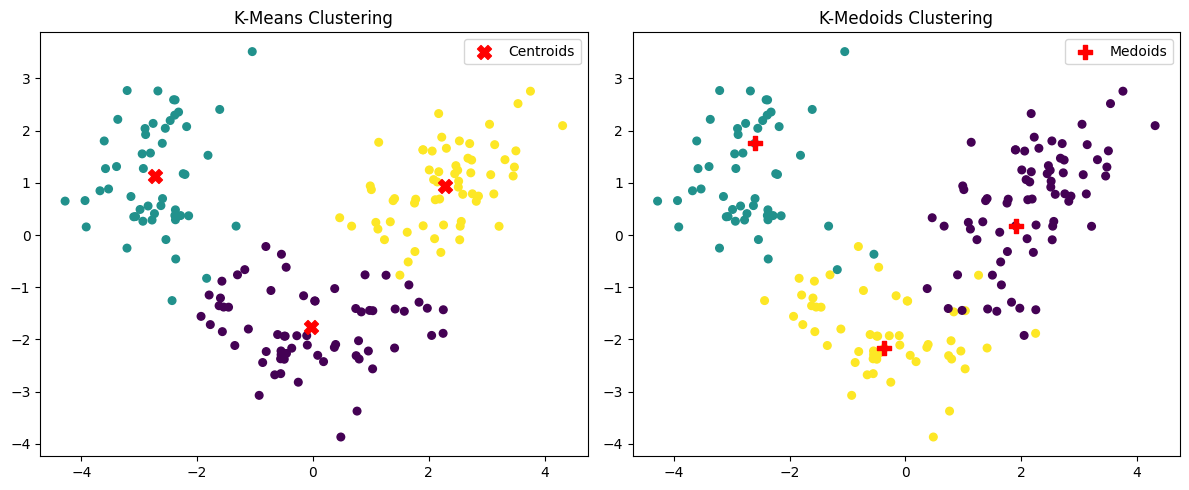

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12,5))

# K-Means plot
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='viridis', s=30)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:,0],
            pca.transform(kmeans.cluster_centers_)[:,1],
            c='red', marker='X', s=100, label='Centroids')
plt.title("K-Means Clustering")
plt.legend()

# K-Medoids plot
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmedoids_labels, cmap='viridis', s=30)
plt.scatter(X_pca[medoid_indices, 0], X_pca[medoid_indices, 1],
            c='red', marker='P', s=100, label='Medoids')
plt.title("K-Medoids Clustering")
plt.legend()

plt.tight_layout()
plt.show()
